In [28]:
import pandas as pd
dataset = pd.read_csv("dataset/SMRT_dataset.csv")
dataset.head(5)

,pubchem,rt,inchi,SMILES,scaffold,has_carboxylic_acid,date
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)",[H]/N=C(/N)SCC,NaN,False,12/16/20
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,O=C(Cc1ccccc1)N1CCNC[C@H]1CN1CCCC1,False,8/30/19
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...,CCN1CCC[C@@H]1CNC(=O)c1cc(S(=O)(=O)CC)c(N)cc1OC,O=C(NC[C@H]1CCCN1)c1ccccc1,False,3/28/16
3,1340,583.6,InChI=1S/C9H7NO2/c11-8-3-1-2-7-6(8)4-5-10-9(7)...,O=c1[nH]ccc2c(O)cccc12,O=c1[nH]ccc2ccccc12,False,8/28/19
4,3344,579.0,InChI=1S/C15H20N2O2/c18-14-16-12-15(19-14)7-10...,O=C1NCC2(CCN(CCc3ccccc3)CC2)O1,O=C1NCC2(CCN(CCc3ccccc3)CC2)O1,False,9/21/19


# Section 1. Visualize the predicting endpoint with hist and box plot

In [27]:
import plotly.express as px
from plotly.subplots import make_subplots

# Visualize the rt column (response) with a 1x2 layout: histogram + box plot
hist = px.histogram(
    dataset,
    x='rt',
    nbins=50,
    labels={'rt': 'RT (Retention Time, Seconds)', 'count': 'Frequency'},
).update_traces(marker_line_color='black', marker_line_width=1, opacity=0.7)

box = px.box(
    dataset,
    y='rt',
    points='outliers',
    labels={'rt': 'RT (Retention Time, Seconds)'},
)

fig = make_subplots(
    rows=1,
    cols=2,
    horizontal_spacing=0.12,
    shared_yaxes=False,
    subplot_titles=("", "") # Empty titles to reserve space if needed, or just handle manually
 )

for trace in hist.data:
    fig.add_trace(trace, row=1, col=1)
for trace in box.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    showlegend=False,
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=30, b=20),
 )

fig.update_xaxes(title_text='RT (Retention Time, Seconds)', row=1, col=1)
fig.update_yaxes(title_text='Frequency', row=1, col=1)

# Box plot: y-axis is RT; hide the categorical x-axis ticks
fig.update_xaxes(title_text='RT (Retention Time, Seconds)', row=1, col=2)
fig.update_yaxes(title_text='RT (Retention Time, Seconds)', row=1, col=2)

# Add "a)" and "b)" labels
fig.add_annotation(
    text="<b>a)</b>",
    xref="paper", yref="paper",
    x=0, y=1.05,  # Top-left of the first subplot area (approx)
    showarrow=False,
    font=dict(size=14, color="red")
)

fig.add_annotation(
    text="<b>b)</b>",
    xref="paper", yref="paper",
    x=0.56, y=1.05, # Top-left of the second subplot area (approx, based on horizontal_spacing)
    showarrow=False,
    font=dict(size=14, color="red")
)

fig.show()

# Save
fig.write_image("images/Figure-1.1-rt(Fig. 1).svg")

# Section 2. Similarity based chemical response analysis and data cleaning

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from src.chem_utils import image_bg_change
import numpy as np
import re

# Calculate Morgan fingerprints for all molecules using the latest method
def calculate_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Use the latest GetMorganGenerator method
        morgan_gen = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
        return morgan_gen.GetFingerprint(mol)
    return None

print("Calculating Morgan fingerprints for all molecules...")
dataset['fingerprint'] = dataset['SMILES'].apply(calculate_fingerprint)

# Remove rows where fingerprint calculation failed
dataset_clean = dataset[dataset['fingerprint'].notna()].copy()
print(f"Successfully calculated fingerprints for {len(dataset_clean)} molecules")

# Function to find most similar molecules to a given row using BulkTanimotoSimilarity
def find_most_similar(row_index, dataset, n_similar=5):
    """
    Find the n most similar molecules to the molecule at row_index
    Returns indices of most similar molecules (excluding itself)
    Uses BulkTanimotoSimilarity for faster computation
    """
    query_fp = dataset.iloc[row_index]['fingerprint']
    
    # Get all fingerprints as a list
    all_fps = dataset['fingerprint'].tolist()
    
    # Calculate similarities to all molecules using BulkTanimotoSimilarity
    similarities = DataStructs.BulkTanimotoSimilarity(query_fp, all_fps)
    
    # Create list of (index, similarity) tuples, excluding the query itself
    similarity_pairs = []
    for i, (idx, sim) in enumerate(zip(dataset.index, similarities)):
        if i != row_index:  # Exclude the query molecule itself
            similarity_pairs.append((idx, sim))
    
    # Sort by similarity (descending)
    similarity_pairs.sort(key=lambda x: x[1], reverse=True)
    
    return similarity_pairs[:n_similar]

# Example: Find molecules most similar to row 0
query_idx = 0
similar_molecules = find_most_similar(query_idx, dataset_clean, n_similar=5)

print(f"\nMolecules most similar to row {query_idx}:")
print(f"Query molecule RT: {dataset_clean.iloc[query_idx]['rt']:.2f} seconds")
print("\nTop 5 most similar molecules:")
for idx, sim in similar_molecules:
    rt_value = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['rt']
    print(f"  Index {idx}: Similarity = {sim:.3f}, RT = {rt_value:.2f} seconds")

Calculating Morgan fingerprints for all molecules...
Successfully calculated fingerprints for 80038 molecules

Molecules most similar to row 0:
Query molecule RT: 93.50 seconds

Top 5 most similar molecules:
  Index 3205: Similarity = 0.271, RT = 787.00 seconds
  Index 334: Similarity = 0.255, RT = 766.60 seconds
  Index 3598: Similarity = 0.194, RT = 805.30 seconds
  Index 5820: Similarity = 0.189, RT = 86.80 seconds
  Index 434: Similarity = 0.175, RT = 94.50 seconds


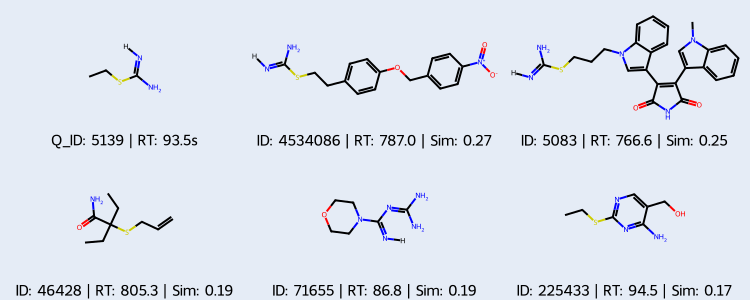

In [21]:
# Visualize query molecule and most similar molecules
query_idx = 0
n_similar = 5  # Number of similar molecules to display
similar_molecules = find_most_similar(query_idx, dataset_clean, n_similar=n_similar)

# Get query molecule and RT value
query_smiles = dataset_clean.iloc[query_idx]['SMILES']
query_rt = dataset_clean.iloc[query_idx]['rt']
query_mol = Chem.MolFromSmiles(query_smiles)

# Prepare molecules and labels
mols_to_display = [query_mol]
labels = [f"Q_ID: {dataset_clean.iloc[query_idx]['pubchem']} | RT: {query_rt:.1f}s"]

# Add similar molecules
for idx, sim in similar_molecules:
    similar_smiles = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['SMILES']
    similar_rt = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['rt']
    pubchem_idx = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['pubchem']
    similar_mol = Chem.MolFromSmiles(similar_smiles)
    
    mols_to_display.append(similar_mol)
    labels.append(f"ID: {pubchem_idx} | RT: {similar_rt:.1f} | Sim: {sim:.2f}")

# Create drawing options with custom background color
draw_options = rdMolDraw2D.MolDrawOptions()
draw_options.clearBackground = True
draw_options.backgroundColour = (229/255, 236/255, 246/255, 1.0)
draw_options.padding = 0.01
draw_options.legendFontSize = 15
draw_options.legendFraction = 0.1

# Draw molecules in a grid (query + n_similar molecules)
img = Draw.MolsToGridImage(
    mols_to_display,
    molsPerRow=3,
    subImgSize=(250, 150),
    legends=labels,
    useSVG=True,
    drawOptions=draw_options
)


# Apply background color style
svg_data = image_bg_change(img)
display(svg_data)
if svg_data:
    svg_content = svg_data.data if hasattr(svg_data, 'data') else svg_data
    with open("images/Figure-1.1.1-example-of-nearest-neighbor.svg", "w") as f:
        f.write(svg_content)


## Example 1--chemicals with very small retention time

In [46]:
# Filter out chemicals with very small RT values
rt_threshold = 50  # Define threshold for "very small" RT (in seconds)

# Identify rows with small RT
small_rt_mask = dataset_clean['rt'] < rt_threshold
small_rt_data = dataset_clean[small_rt_mask]
large_rt_data = dataset_clean[~small_rt_mask]

print(f"RT threshold: {rt_threshold} seconds")
print(f"Number of chemicals with RT < {rt_threshold}s: {len(small_rt_data)}")
print(f"Number of chemicals with RT >= {rt_threshold}s: {len(large_rt_data)}")
print(f"\nPercentage filtered out: {len(small_rt_data)/len(dataset_clean)*100:.2f}%")

# Show some examples of filtered out chemicals
print(f"\nExamples of chemicals with very small RT values:")
print(small_rt_data[['pubchem','SMILES', 'rt']].head(10))

# Create filtered dataset
dataset_filtered = large_rt_data.copy()
print(f"\nFiltered dataset shape: {dataset_filtered.shape}")

RT threshold: 50 seconds
Number of chemicals with RT < 50s: 9
Number of chemicals with RT >= 50s: 80029

Percentage filtered out: 0.01%

Examples of chemicals with very small RT values:
        pubchem                                             SMILES   rt
362        1734         C[N+]1(C)CCC(OC(=O)C(c2ccccc2)c2ccccc2)CC1  0.3
367        4022                C[N+](C)(C)CC#CCOC(=O)Nc1cccc(Cl)c1  0.3
368        5275             COc1ccc(-c2ccc(N)[n+](CCCC(=O)O)n2)cc1  0.3
3294    4605800  O=S1(=O)N(CCN2CC=C(c3c[nH]c4cc(F)ccc34)CC2)c2c...  0.3
3651     475318  CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)[O-])=C(CS...  0.3
14389  16759590  CN(CC[C@@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1)CC(=O...  0.3
26957  25085166  Nc1ncnc2c1nc(Br)n2[C@H]1O[C@@H]2CO[P@@](=O)(O)...  0.3
27268  25897907  O=C([O-])[C@H](CC(=O)N1C[C@H]2CCCC[C@H]2C1)Cc1...  0.3
33402  44433028  CCN(CC)Cc1ccc(C(=O)N(CCc2ccccc2OC)[C@H]2CCNC2)cc1  0.3

Filtered dataset shape: (80029, 6)


Found molecule with SMILES: CCN(CC)Cc1ccc(C(=O)N(CCc2ccccc2OC)[C@H]2CCNC2)cc1
Index in dataset_clean: 33402
Original index: 33402
RT value: 0.30s


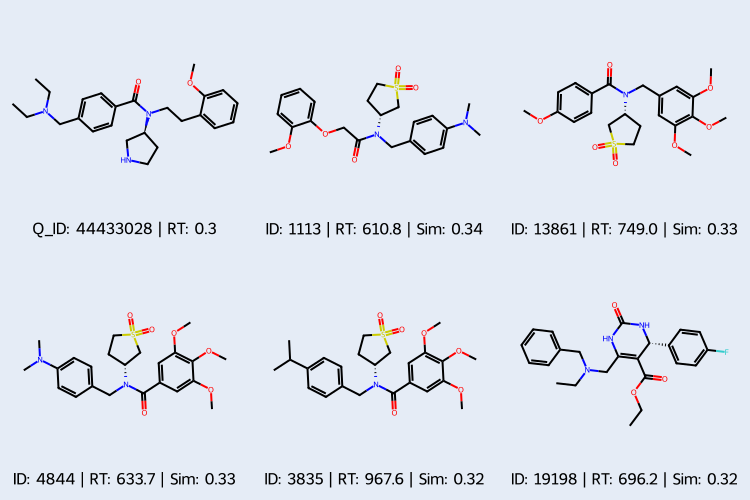

In [74]:
from IPython.display import SVG, display
from src.chem_utils import image_bg_change

# Find index in dataset using SMILES
query_smiles_str = "CCN(CC)Cc1ccc(C(=O)N(CCc2ccccc2OC)[C@H]2CCNC2)cc1"

# Find the index of the molecule with this SMILES
matching_indices = dataset_clean[dataset_clean['SMILES'] == query_smiles_str].index.tolist()

if len(matching_indices) > 0:
    query_idx = dataset_clean.index.get_loc(matching_indices[0])
    print(f"Found molecule with SMILES: {query_smiles_str}")
    print(f"Index in dataset_clean: {query_idx}")
    print(f"Original index: {matching_indices[0]}")
    print(f"RT value: {dataset_clean.iloc[query_idx]['rt']:.2f}s")
else:
    print(f"No molecule found with SMILES: {query_smiles_str}")
    print("Using default query_idx = 0")
    query_idx = 0

# Visualize query molecule and most similar molecules
n_similar = 5  # Number of similar molecules to display
similar_molecules = find_most_similar(query_idx, dataset_clean, n_similar=n_similar)

# Get query molecule and RT value
query_smiles = dataset_clean.iloc[query_idx]['SMILES']
query_rt = dataset_clean.iloc[query_idx]['rt']
query_mol = Chem.MolFromSmiles(query_smiles)

# Prepare molecules and labels
mols_to_display = [query_mol]
labels = [f"Q_ID: {dataset_clean.iloc[query_idx]['pubchem']} | RT: {query_rt:.1f}"]

# Add similar molecules
for idx, sim in similar_molecules:
    similar_smiles = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['SMILES']
    similar_rt = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['rt']
    pubchem_idx = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['pubchem']
    similar_mol = Chem.MolFromSmiles(similar_smiles)
    
    mols_to_display.append(similar_mol)
    labels.append(f"ID: {idx} | RT: {similar_rt:.1f} | Sim: {sim:.2f}")

# Create drawing options with custom background color
draw_options = rdMolDraw2D.MolDrawOptions()
draw_options.clearBackground = True
draw_options.backgroundColour = (229/255, 236/255, 246/255, 1.0)

# Draw molecules in a grid (query + n_similar molecules)
img = Draw.MolsToGridImage(
    mols_to_display,
    molsPerRow=3,
    subImgSize=(250, 250),
    legends=labels,
    useSVG=True,
    drawOptions=draw_options
)

# Apply background color style
svg_data = image_bg_change(img)
display(svg_data)
if svg_data:
    svg_content = svg_data.data if hasattr(svg_data, 'data') else svg_data
    with open("images/Figure-1.1.2-Outlier-of-very-small-rt.svg", "w") as f:
        f.write(svg_content)

## Exmple 2--chemicals with very large retention times

In [75]:
# Filter out chemicals with very large RT values
rt_threshold = 1425  # Define threshold for "very large" RT (in seconds)

# Identify rows with large RT
large_rt_mask = dataset_clean['rt'] > rt_threshold
large_rt_data = dataset_clean[large_rt_mask]
small_rt_data = dataset_clean[~large_rt_mask]

print(f"RT threshold: {rt_threshold} seconds")
print(f"Number of chemicals with RT > {rt_threshold}s: {len(large_rt_data)}")
print(f"Number of chemicals with RT <= {rt_threshold}s: {len(small_rt_data)}")
print(f"\nPercentage filtered out: {len(large_rt_data)/len(dataset_clean)*100:.2f}%")

# Show some examples of filtered out chemicals
print(f"\nExamples of chemicals with very large RT values:")
print(large_rt_data[['pubchem','SMILES', 'rt']].head(10))

# Create filtered dataset
dataset_filtered = small_rt_data.copy()
print(f"\nFiltered dataset shape: {dataset_filtered.shape}")

RT threshold: 1425 seconds
Number of chemicals with RT > 1425s: 24
Number of chemicals with RT <= 1425s: 80014

Percentage filtered out: 0.03%

Examples of chemicals with very large RT values:
        pubchem                                             SMILES      rt
3285    4605276     O=C(Nc1nc(-c2ccccc2)c(-c2ccccc2)s1)c1ccc(Br)s1  1462.8
7199    1188914      Cc1ccc(C)c(OCC(=O)Nc2nc(-c3ccc(Br)cc3)cs2)c1C  1427.8
7585    1495801     FC(F)(F)c1cc(-c2cccs2)n(-c2nc(-c3ccccc3)cs2)n1  1453.3
7802    1758504    CCOc1cccc(C(=O)Nc2nc(-c3ccc(C(C)(C)C)cc3)cs2)c1  1428.6
13119  16024794  Cc1cccc(N2CCN(c3ccc4cc(S(=O)(=O)N5CCC(C)CC5)cc...  1457.2
13380  16031116  CCOc1ccc([C@@H]2c3[nH]c4ccccc4c3CCN2C(=O)CCC2C...  1455.1
16551  22511562  CN1C(=O)c2ccccc2Sc2ccc(NC(=O)N3CCC(C(N)=O)CC3)...  1429.6
17886  22585333  Cc1ccc(Nc2cc(C)nc(N3CCN(C(=O)Nc4cccc(C)c4)CC3)...  1455.1
37404  53037337   Cc1cccc(OCc2nc(-c3cccc(-c4csc(C5CC5)n4)c3)no2)c1  1432.7
38259  53034814    COc1ccc(OC(=O)c2cc3c(C)nn(-c4cccc(F)c4

Found molecule with SMILES: O=C(Nc1nc(-c2ccccc2)c(-c2ccccc2)s1)c1ccc(Br)s1
Index in dataset_clean: 3285
Original index: 3285
RT value: 1462.80s


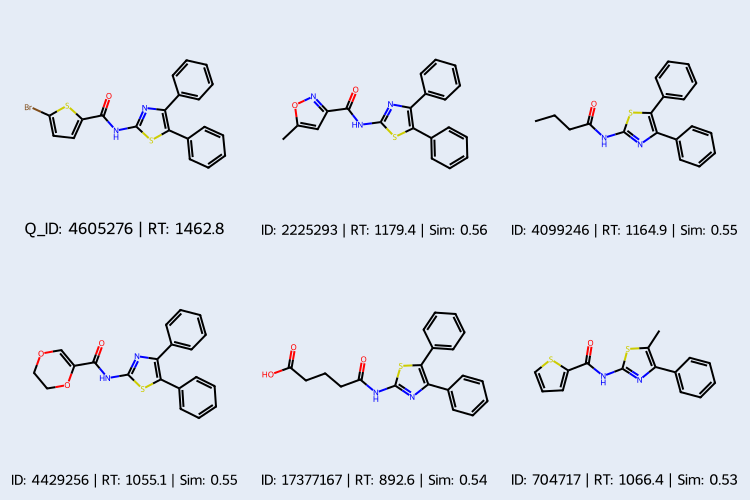

In [ ]:
# Find index in dataset using SMILES
query_smiles_str = "O=C(Nc1nc(-c2ccccc2)c(-c2ccccc2)s1)c1ccc(Br)s1"

# Find the index of the molecule with this SMILES
matching_indices = dataset_clean[dataset_clean['SMILES'] == query_smiles_str].index.tolist()

if len(matching_indices) > 0:
    query_idx = dataset_clean.index.get_loc(matching_indices[0])
    print(f"Found molecule with SMILES: {query_smiles_str}")
    print(f"Index in dataset_clean: {query_idx}")
    print(f"Original index: {matching_indices[0]}")
    print(f"RT value: {dataset_clean.iloc[query_idx]['rt']:.2f}s")
else:
    print(f"No molecule found with SMILES: {query_smiles_str}")
    print("Using default query_idx = 0")
    query_idx = 0

# Visualize query molecule and most similar molecules
n_similar = 5  # Number of similar molecules to display
similar_molecules = find_most_similar(query_idx, dataset_clean, n_similar=n_similar)

# Get query molecule and RT value
query_smiles = dataset_clean.iloc[query_idx]['SMILES']
query_rt = dataset_clean.iloc[query_idx]['rt']
query_mol = Chem.MolFromSmiles(query_smiles)

# Prepare molecules and labels
mols_to_display = [query_mol]
labels = [f"Q_ID: {dataset_clean.iloc[query_idx]['pubchem']} | RT: {query_rt:.1f}"]

# Add similar molecules
for idx, sim in similar_molecules:
    similar_smiles = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['SMILES']
    similar_rt = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['rt']
    pubchem_idx = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['pubchem']
    similar_mol = Chem.MolFromSmiles(similar_smiles)
    
    mols_to_display.append(similar_mol)
    labels.append(f"ID: {pubchem_idx} | RT: {similar_rt:.1f} | Sim: {sim:.2f}")
# Create drawing options with custom background color
draw_options = rdMolDraw2D.MolDrawOptions()
draw_options.clearBackground = True
draw_options.backgroundColour = (229/255, 236/255, 246/255, 1.0)

# Draw molecules in a grid (query + n_similar molecules)
img = Draw.MolsToGridImage(
    mols_to_display,
    molsPerRow=3,
    subImgSize=(250, 250),
    legends=labels,
    useSVG=True,
    drawOptions=draw_options
)
# Apply background color style
svg_data = image_bg_change(img)
display(svg_data)
if svg_data:
    svg_content = svg_data.data if hasattr(svg_data, 'data') else svg_data
    with open("images/Figure-1.1.3-example-of-very-large-rt.svg", "w") as f:
        f.write(svg_content)

## Example 3--using certain substructure to do data clearning

In [4]:
# Select rows with carboxylic acid (or carboxylate) substructures using RDKit
from rdkit import Chem

# SMARTS for neutral carboxylic acid and deprotonated carboxylate
acid_smarts = "[CX3](=O)[OX2H1]"       # e.g., -C(=O)OH
#carboxylate_smarts = "[CX3](=O)[O-]"   # e.g., -C(=O)O-

acid_pat = Chem.MolFromSmarts(acid_smarts)
#carboxylate_pat = Chem.MolFromSmarts(carboxylate_smarts)

# Helper to check if a SMILES contains either pattern
def has_carboxylic_or_carboxylate(smiles: str) -> bool:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        return mol.HasSubstructMatch(acid_pat) #or mol.HasSubstructMatch(carboxylate_pat)
    except Exception:
        return False

# Add boolean flag and filter dataset
print("Tagging rows containing carboxylic acid substructures...")
dataset_clean['has_carboxylic_acid'] = dataset_clean['SMILES'].apply(has_carboxylic_or_carboxylate)

dataset_carboxylic = dataset_clean[dataset_clean['has_carboxylic_acid']].copy()

print(f"Total rows: {len(dataset_clean)}")
print(f"Rows with carboxylic acid: {len(dataset_carboxylic)}")
print("\nPreview:")
print(dataset_carboxylic[['pubchem','SMILES','rt']].sort_values('rt').head(10))

Tagging rows containing carboxylic acid substructures...
Total rows: 80038
Rows with carboxylic acid: 1364

Preview:
        pubchem                                             SMILES    rt
368        5275             COc1ccc(-c2ccc(N)[n+](CCCC(=O)O)n2)cc1   0.3
3935    5310984                  N[C@@]1(C(=O)O)CN[C@@H](C(=O)O)C1  67.0
3936    5311457              C[C@@](N)(C(=O)O)[C@H]1C[C@@H]1C(=O)O  72.8
7805    1795545                        C[C@](N)(CCP(=O)(O)O)C(=O)O  79.9
65050  50766929  O=C(O)c1cc(NS(=O)(=O)c2ccc(F)cc2)ccc1N1CCC[C@H...  82.6
33708  52992020            O=C(O)[C@@H]1CCCN(c2ccc(-n3ccnc3)nn2)C1  83.5
8014    2052633                        Nc1ccc(-c2ccc(C(=O)O)s2)cn1  83.6
211       23327                             N[C@H](CCC(=O)O)C(=O)O  83.6
6891      75896                        N[C@@H](CC[S@@](=O)O)C(=O)O  83.9
3289    4612536                    O=C(O)CSc1nc(=O)c2[nH]cnc2[nH]1  84.1


Found molecule with SMILES: N[C@@]1(C(=O)O)CN[C@@H](C(=O)O)C1
Index in dataset_clean: 3935
Original index: 3935
RT value: 67.00s


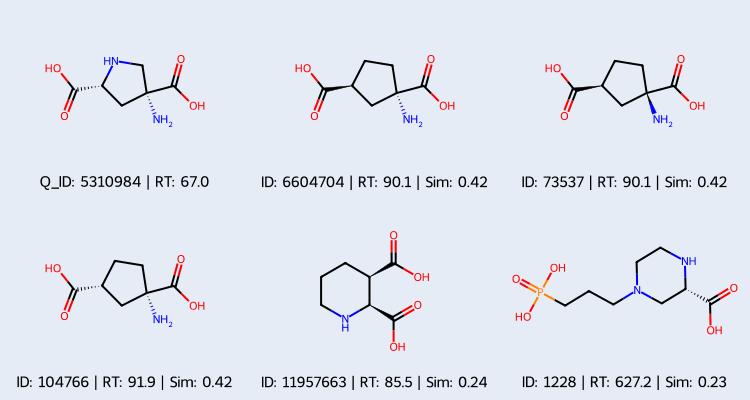

In [23]:
# Find index in dataset using SMILES
query_smiles_str = "N[C@@]1(C(=O)O)CN[C@@H](C(=O)O)C1" #"N[C@H](CCC(=O)O)C(=O)O"

# Find the index of the molecule with this SMILES
matching_indices = dataset_clean[dataset_clean['SMILES'] == query_smiles_str].index.tolist()

if len(matching_indices) > 0:
    query_idx = dataset_clean.index.get_loc(matching_indices[0])
    print(f"Found molecule with SMILES: {query_smiles_str}")
    print(f"Index in dataset_clean: {query_idx}")
    print(f"Original index: {matching_indices[0]}")
    print(f"RT value: {dataset_clean.iloc[query_idx]['rt']:.2f}s")
else:
    print(f"No molecule found with SMILES: {query_smiles_str}")
    print("Using default query_idx = 0")
    query_idx = 0

# Visualize query molecule and most similar molecules
n_similar = 5  # Number of similar molecules to display
similar_molecules = find_most_similar(query_idx, dataset_clean, n_similar=n_similar)

# Get query molecule and RT value
query_smiles = dataset_clean.iloc[query_idx]['SMILES']
query_rt = dataset_clean.iloc[query_idx]['rt']
query_mol = Chem.MolFromSmiles(query_smiles)

# Prepare molecules and labels
mols_to_display = [query_mol]
labels = [f"Q_ID: {dataset_clean.iloc[query_idx]['pubchem']} | RT: {query_rt:.1f}"]

# Add similar molecules
for idx, sim in similar_molecules:
    similar_smiles = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['SMILES']
    similar_rt = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['rt']
    pubchem_idx = dataset_clean.iloc[dataset_clean.index.get_loc(idx)]['pubchem']
    similar_mol = Chem.MolFromSmiles(similar_smiles)
    
    mols_to_display.append(similar_mol)
    labels.append(f"ID: {pubchem_idx} | RT: {similar_rt:.1f} | Sim: {sim:.2f}")
# Create drawing options with custom background color
draw_options = rdMolDraw2D.MolDrawOptions()
draw_options.clearBackground = True
draw_options.backgroundColour = (229/255, 236/255, 246/255, 1.0)
draw_options.legendFontSize = 15 # Adjust the font size of the label (default is usually smaller)
draw_options.padding = 0.05 # Revert padding to default or adjust as needed
draw_options.legendFraction = 0.1 # Adjust the vertical space allocated for the legend (default is dynamically calculated, but explicit value helps positioning)

# Draw molecules in a grid (query + n_similar molecules)
img = Draw.MolsToGridImage(
    mols_to_display,
    molsPerRow=3,
    subImgSize=(250, 200),
    legends=labels,
    useSVG=True,
    drawOptions=draw_options
)
# Apply background color style
svg_data = image_bg_change(img)
display(svg_data)
if svg_data:
    svg_content = svg_data.data if hasattr(svg_data, 'data') else svg_data
    with open("images/Figure-1.1.4-example-of-certain-substructure-rt.svg", "w") as f:
        f.write(svg_content)

# Section 3. Visulize the data distribution of the chemicals in the dataset based on scaffold

In [80]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_scaffold(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            return Chem.MolToSmiles(scaffold)
        return None
    except:
        return None

# The dataset has a SMILES column, adjust the column name if needed for other datasets
#dataset['scaffold'] = dataset['SMILES'].apply(get_scaffold)

# Count chemicals by scaffold
scaffold_counts = dataset['scaffold'].value_counts()
total_scaffolds = scaffold_counts.shape[0]
avg_molecules_per_scaffold = scaffold_counts.mean()

# Top K scaffolds for visualization
top_k = 10
top_k_scaffolds = scaffold_counts.head(top_k)
x_label = [f'Top_{i}' for i in range(1, top_k + 1)] # using "top_k_scaffolds.index" for real scaffold
# Visualize
fig = px.bar(x=x_label, y=top_k_scaffolds.values,
             #title='Chemical Counts by Top 10 Scaffold',
             labels={'x': 'Scaffolds', 'y': 'Count'})
fig.update_layout(plot_bgcolor='rgba(229, 236, 246,1)',
                  paper_bgcolor='rgba(229, 236, 246,1)',
                  width=600,
                  height=400,
                  margin=dict(l=20, r=20, t=30, b=20),
                  )

# Add text annotations
fig.add_annotation(
    text=f'Total Scaffolds: {total_scaffolds}<br>Avg. Molecules/Scaffold: {avg_molecules_per_scaffold:.2f}',
    xref="paper", yref="paper",
    x=0.98, y=0.8,
    showarrow=False,
    font=dict(size=12, color="black"),
    align="right",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="black",
    borderwidth=1
)

fig.show()
fig.write_image("images/Figure-1.2-scaffolds.svg")

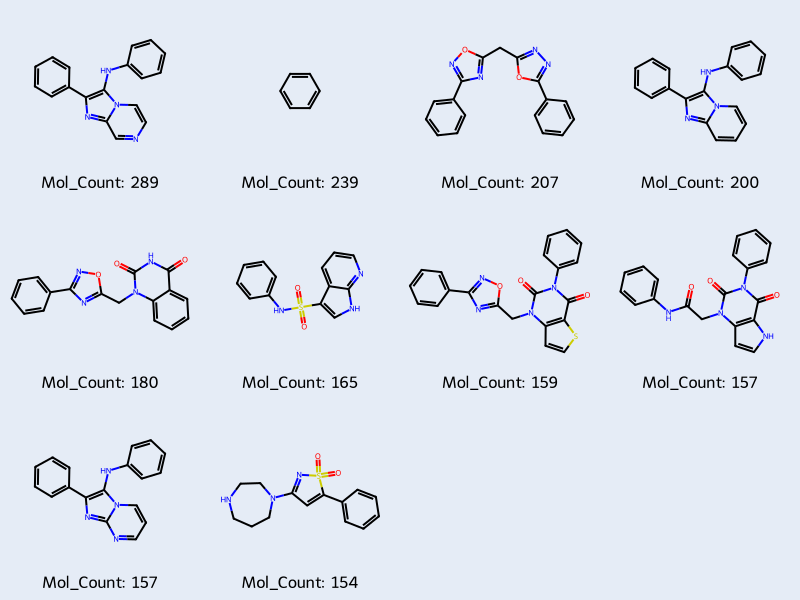

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# Get top 10 scaffolds
top_10_scaffold_smiles = top_k_scaffolds.index.tolist()

# Convert SMILES to molecule objects
scaffold_mols = [Chem.MolFromSmiles(smi) for smi in top_10_scaffold_smiles if smi is not None]

# Create labels with counts
labels = [f"Mol_Count: {top_k_scaffolds[smi]}" for smi in top_10_scaffold_smiles if smi is not None]

# Create drawing options with custom background color
draw_options = rdMolDraw2D.MolDrawOptions()
draw_options.clearBackground = True
draw_options.backgroundColour = (229/255, 236/255, 246/255, 1.0)

# Draw molecules in a grid with custom background
img = Draw.MolsToGridImage(scaffold_mols, molsPerRow=4, subImgSize=(200, 200), 
                           legends=labels, useSVG=True,
                           drawOptions=draw_options)
# Apply background color style
svg_data = image_bg_change(img)
display(svg_data)
if svg_data:
    svg_content = svg_data.data if hasattr(svg_data, 'data') else svg_data
    with open("images/Figure-1.2.1-molecules-count-top10-scaffold.svg", "w") as f:
        f.write(svg_content)

## Analyse the chemicals from a specific scaffold

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_scaffold(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            return Chem.MolToSmiles(scaffold)
        return None
    except:
        return None

# Calculate Morgan fingerprints for all molecules using the latest method
#dataset = pd.read_csv("dataset/SMRT_dataset.csv")
dataset = pd.read_csv("dataset/SMRT_dataset_processed.csv.sdf")
dataset['scaffold'] = dataset.SMILES.apply(get_scaffold)
scaffold_counts = dataset['scaffold'].value_counts()

def calculate_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Use the latest GetMorganGenerator method
        morgan_gen = AllChem.GetMorganGenerator(radius=radius, fpSize=nBits)
        return morgan_gen.GetFingerprint(mol)
    return None
example_scaffold = scaffold_counts.index[0]
scaffold_data = dataset[dataset['scaffold'] == example_scaffold].copy()

In [14]:
scaffold_data['fingerprint'] = scaffold_data['SMILES'].apply(calculate_fingerprint)

In [ ]:
def get_top_similar_chemicals(df, fp_col='fingerprint', rt_col='rt', top_k=10):
    """
    For each row in df, find the top_k most similar chemicals (based on fp_col)
    and return their indices, similarity scores, RT values, and RSDs.
    """
    # Check if columns exist
    if fp_col not in df.columns or rt_col not in df.columns:
        print(f"Error: Columns {fp_col} or {rt_col} not found.")
        return df

    fps = list(df[fp_col])
    rts = df[rt_col].values
    n = len(fps)
    
    top_indices = []
    top_scores = []
    top_rts = []
    
    print(f"Processing {n} molecules...")
    
    for i in range(n):
        # Calculate similarity to all others
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        sims = np.array(sims)
        
        # Mask self-similarity
        sims[i] = -1.0
        
        # Get top k indices
        # argpartition is efficient for large arrays
        if n > top_k:
            idx_unsorted = np.argpartition(sims, -top_k)[-top_k:]
            # Sort these top k
            idx_sorted = idx_unsorted[np.argsort(sims[idx_unsorted])[::-1]]
        else:
            idx_sorted = np.argsort(sims)[::-1][:n-1]
            
        top_indices.append(idx_sorted)
        top_scores.append(sims[idx_sorted])
        top_rts.append(rts[idx_sorted])
        
    # Assign to new columns
    df_new = df.copy()
    df_new[f'top{top_k}_indices'] = top_indices
    df_new[f'top{top_k}_scores'] = top_scores
    df_new[f'top{top_k}_rts'] = top_rts
    
    # Calculate RSD (Relative Standard Deviation)
    def calculate_rsd(values):
        values = np.array(values)
        if len(values) == 0 or np.mean(values) == 0:
            return 0.0
        return (np.std(values) / np.mean(values)) * 100

    df_new[f'top{top_k}_sim_rsd'] = df_new[f'top{top_k}_scores'].apply(calculate_rsd)
    df_new[f'top{top_k}_rt_rsd'] = df_new[f'top{top_k}_rts'].apply(calculate_rsd)
    
    return df_new

# Determine which dataframe to use
if 'dataset_clean' in locals():
    target_df = dataset_clean
    print("Calculating for dataset_clean...")
elif 'scaffold_data' in locals():
    target_df = scaffold_data
    print("Calculating for scaffold_data...")
else:
    print("No suitable dataframe found (dataset_clean or scaffold_data).")
    target_df = None

if target_df is not None:
    dataset_with_sim = get_top_similar_chemicals(target_df)
    print("Done.")
    # Display a sample
    print(dataset_with_sim[['SMILES', 'rt', f'top10_scores', f'top10_rts', f'top10_sim_rsd', f'top10_rt_rsd']].head(5))

Calculating for dataset_clean...
Done.
                                              SMILES     rt  \
0                                     [H]/N=C(/N)SCC   93.5   
1  COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...  687.8   
2    CCN1CCC[C@@H]1CNC(=O)c1cc(S(=O)(=O)CC)c(N)cc1OC  590.7   
3                             O=c1[nH]ccc2c(O)cccc12  583.6   
4                     O=C1NCC2(CCN(CCc3ccccc3)CC2)O1  579.0   

                                        top10_scores  \
0  [0.2708333333333333, 0.2545454545454545, 0.194...   
1  [0.391304347826087, 0.3880597014925373, 0.3880...   
2  [0.5, 0.5, 0.45454545454545453, 0.449275362318...   
3  [0.4523809523809524, 0.37142857142857144, 0.33...   
4  [0.39655172413793105, 0.38333333333333336, 0.3...   

                                           top10_rts  top10_sim_rsd  \
0  [787.0, 766.6, 805.3, 86.8, 94.5, 839.2, 110.0...      22.245148   
1  [718.1, 730.4, 773.6, 650.8, 626.7, 793.7, 621...       3.623012   
2  [585.5, 776.6, 622.0, 89.2, 6

In [ ]:
# export file for visual analysis
dataset_with_sim[['SMILES', 'rt', 'top5_scores', 'top5_rts', 'top5_sim_rsd', 'top5_rt_rsd']].to_csv("temp.csv")

Selected Row Index: 37542


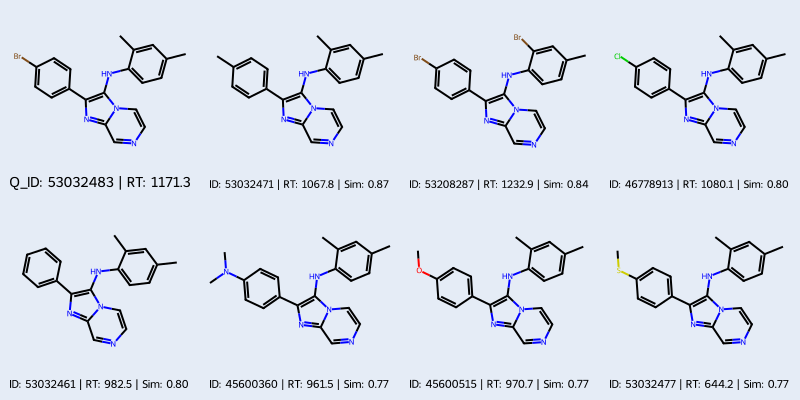

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display

row_idx = dataset_with_sim.loc[dataset_with_sim['pubchem'] == 53032483].index[0]
# Ensure we have the dataset
if 'dataset_with_sim' in locals():
    df_target = dataset_with_sim
    
    print(f"Selected Row Index: {row_idx}")
    
    # Get Reference Molecule Details
    ref_row = df_target.iloc[row_idx]
    ref_smiles = ref_row['SMILES']
    ref_rt = ref_row['rt']
    ref_pubchem = ref_row['pubchem'] if 'pubchem' in ref_row else 'N/A'
    ref_mol = Chem.MolFromSmiles(ref_smiles)
    
    # Lists to hold molecules and legends
    mols_to_draw = [ref_mol]
    legends = [f"Q_ID: {ref_pubchem} | RT: {ref_rt:.1f}"]
    
    # Get Top 10 Similar Molecules Details
    top_indices = ref_row['top10_indices']
    top_scores = ref_row['top10_scores']
    top_rts = ref_row['top10_rts']
    
    #for i in range(len(top_indices)):
    for i in range(7):
        sim_idx = top_indices[i]
        sim_score = top_scores[i]
        sim_rt = top_rts[i]
        
        # Get SMILES for the similar molecule
        sim_row = df_target.iloc[sim_idx]
        sim_smiles = sim_row['SMILES']
        sim_pubchem = sim_row['pubchem'] if 'pubchem' in sim_row else 'N/A'
        sim_mol = Chem.MolFromSmiles(sim_smiles)
        
        mols_to_draw.append(sim_mol)
        legends.append(f"ID: {sim_pubchem} | RT: {sim_rt:.1f} | Sim: {sim_score:.2f} ")
        
    # Visualization Configuration
    draw_options = rdMolDraw2D.MolDrawOptions()
    draw_options.clearBackground = True
    draw_options.backgroundColour = (229/255, 236/255, 246/255, 1.0) # Light blue-ish background
    
    # Generate Image
    img = Draw.MolsToGridImage(
        mols_to_draw,
        molsPerRow=4,
        subImgSize=(200, 200),
        legends=legends,
        drawOptions=draw_options,
        useSVG=True
    )
    
    # Display
    svg_data = image_bg_change(img)
    display(svg_data)
    if svg_data:
        svg_content = svg_data.data if hasattr(svg_data, 'data') else svg_data
        with open("images/Figure-1.2.2-mol-analysis-based-on-scaffold.svg", "w") as f:
            f.write(svg_content)
else:
    print("Error: 'dataset_with_sim' dataframe not found. Please run the similarity calculation cell first.")

# Chronological trend of the HPLC RT dataset

In [ ]:
# Histogram of dates for chemicals with top 10 scaffolds - each scaffold in different color
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# Get top 10 scaffolds
scaffold_counts = dataset_clean['scaffold'].value_counts()
top_10_scaffold_list = scaffold_counts.head(10).index.tolist()

# Filter data to only include top 10 scaffolds
data_top_10_scaffolds = dataset_clean[dataset_clean['scaffold'].isin(top_10_scaffold_list)].copy()

# Convert date to datetime for plotting
data_top_10_scaffolds['date_dt'] = pd.to_datetime(data_top_10_scaffolds['date'])

# Aggregate data by month
data_top_10_scaffolds['year_month'] = data_top_10_scaffolds['date_dt'].dt.to_period('M').dt.to_timestamp()

print(f"Number of chemicals with top 10 scaffolds: {len(data_top_10_scaffolds)}")
print(f"Date range: {data_top_10_scaffolds['date'].min()} to {data_top_10_scaffolds['date'].max()}")

# Create figure
fig = go.Figure()

# Get color palette
colors = px.colors.qualitative.Plotly

# For each scaffold, aggregate by month and plot
for idx, scaffold in enumerate(top_10_scaffold_list):
    scaffold_data = data_top_10_scaffolds[data_top_10_scaffolds['scaffold'] == scaffold]
    
    # Count chemicals per month
    monthly_counts = scaffold_data.groupby('year_month').size().reset_index(name='count')
    
    # Truncate scaffold label
    scaffold_label = f"{scaffold[:30]}..." if len(scaffold) > 30 else scaffold
    
    # Add line trace
    fig.add_trace(go.Scatter(
        x=monthly_counts['year_month'],
        y=monthly_counts['count'],
        mode='lines',
        name=f"Top_{idx+1}" , # or using "scaffold_label" to show the real scaffold
        line=dict(width=2.5, color=colors[idx % len(colors)])
    ))

fig.update_layout(
    #title='Date Distribution for Top 10 Scaffolds (Monthly Aggregation)',
    xaxis_title='Date',
    yaxis_title='Number of molecules',
    plot_bgcolor='rgba(229, 236, 246,1)',
    paper_bgcolor='rgba(229, 236, 246,1)',
    width=800,
    height=400,
    margin = dict(l=20, r=20, t=30, b=20),
    legend=dict(
        title='Scaffolds',
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=0.7
    )
)

fig.show()
fig.write_image("images/Figure-1.3-scaffolds_chronological.svg")

Number of chemicals with top 10 scaffolds: 1907
Date range: 1/1/16 to 9/9/17


/var/folders/hj/q8mtpn19753261g7vzkd5b7m0000gn/T/ipykernel_50587/3374521694.py:14: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

